# Предсказание оттока клиентов у телекоммуникационной компании.

**Описание проекта:**

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель данного проекта:**

Построить модель для прогнозирования оттока клиентов компании и получить результат минимум 0.85 по метрике ROC-AUC.

**План данного проекта:**

*1. Подготовить данные:*

    - загрузить датасеты и сохранить их в переменные
    - проверить датасеты на наличие пропусков и явных дубликатов
    - объединить датасеты в один и произвести первичный анализ признаков
    
*2. Провести предобработку данных:*
     
    - обработать пропуски, дубликаты, а также аномалии в данных при их наличии
    - изменить неподходящие форматы признаков при их наличии
    - создать дополнительные признаки по необходимости

*3. Провести исследовательский анализ данных:*
     
    - посмотреть на распределение целевого признака
    - построить графики распределения количественных и категориальных признаков в зависимости от целевого признака
    - посмотреть на кореляцию количественнных и категориальных признаков
    - описать найденные закономерности

*4. Построить и обучить модель:*
     
    - проверить есть ли дисбаланс в данных (при наличии дисбаланса использовать стратифицированную выборку)
    - разделить данные на выборки в соотношении: 75% тренировочная и 25% тестовая выборка
    - произвести кодирование и стандартизацию признаков
    - выбрать подходящие под задачу модели обучения
    - произвести подбор гиперпараметров и обучить наилучшим образом модели
    - выбрать лучшую модель и проверить ее на тестовых данных
    - провести анализ важности признаков и вывести матрицу ошибок

*5. Написать вывод*
     
    - написать развернутый вывод по данному проекту

**Описание услуг**

*Оператор предоставляет два основных типа услуг:*

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

*Также доступны такие услуги:*

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Загрузка данных

Установим все необходимые для данного исследования библиотеки.

In [1]:
#!pip install sweetviz -q

#!pip install phik -q

#!pip install catboost -q
#!pip install lightgbm -q

#!pip install scikit-learn==1.1.3

Импортируем все необходимые для данного исследования библиотеки.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sweetviz as sv

import phik

import time

from phik.report import plot_correlation_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.dummy import DummyClassifier

from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline

from IPython.display import display


import warnings


np.warnings = warnings

warnings.filterwarnings('ignore')

SEED=50623

Создадим функцию `read_csv`, которая будет открывать и сохранять наши датасеты в переменные, выводить общую информацию о них на экран для первого ознакомления с данными, а также осуществлять проверку на наличие пропусков и дубликатов в данных.

In [3]:
# создадим функцию read_csv для загрузки и сохранения датасетов в переменные

def read_csv(dataset):
    
    # открываем и сохраняем датасет через конструкцию try/except
    try:
        data = pd.read_csv(f"/datasets/{dataset}")
    except:
        data = pd.read_csv(f"C:\\datasets\\{dataset}")
    
    data.info()
    
    # выводим информацию о наличии пропусков и дубликатов
    print()
    print('Количество дубликатов в датасете:', data.duplicated().sum())
    print()
    print('Количество пропусков в датасете:', data.isna().sum().sum())
    print()
    
    return(data)

Сохраним датасеты в переменные и выведем общую информацию о них, а также посмотрим присутсвуют ли пропуски или дубликаты.

In [4]:
contract = read_csv('contract_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB

Количество дубликатов в датасете: 0

Количество пропусков в датасете: 0



Датасет `contract` состоит из 7043 строк и 8 столбцов. Пропуски и явные дубликаты отсутствуют.

In [5]:
personal = read_csv('personal_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB

Количество дубликатов в датасете: 0

Количество пропусков в датасете: 0



Датасет `personal` состоит из 7043 строк и 5 столбцов. Пропуски и явные дубликаты отсутствуют.

In [6]:
internet = read_csv('internet_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB

Количество дубликатов в датасете: 0

Количество пропусков в датасете: 0



Датасет `internet` состоит из 5517 строк и 8 столбцов. Пропуски и явные дубликаты отсутствуют.

In [7]:
phone = read_csv('phone_new.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB

Количество дубликатов в датасете: 0

Количество пропусков в датасете: 0



Датасет `phone` состоит из 6361 строки и 2 столбцов. Пропуски и явные дубликаты отсутствуют.

Соединим все имеющиеся данные в один датасет по `customerID` и выведем первые десять строк, а также информацию о нем на экран.

In [8]:
# используем merge для объединения датасетов по customerID с сохранением всех данных с первого датасета
data = contract.merge(personal, on = 'customerID', how = 'left') \
               .merge(internet, on = 'customerID', how = 'left') \
               .merge(phone, on = 'customerID', how = 'left')

In [9]:
display(data.head(10))

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


При визуальном осмотре датасета видно наличие в столбце `EndDate` помимо даты значения "No". Скорее всего это оставшиеся клиенты.

In [10]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


None

После объединения всех датасетов в один мы видим следующее:
    
 - в объединенном датасете присутствует 7043 строки и 20 столбцов
 
 
 - тип "object" имеют 18 признаков еще 2 признака имеют типы "float64" и "int64"
 
 
 - в столбце `BeginDate` и `EndDate`не соответствует формат данных (исходя из названия они должны иметь тип "datetime")
 
 
 - в столбце `TotalCharges` необходимо поменять формат данных на числовой
 
 
 - после объединения появились пропуски в столбцах, так как в исходных датасетах было разное количество строк

Для более полного анализа данных в датасете используем функцию `sv.analyze` из установленной в начале проекта библиотеки `sweetviz`.

In [11]:
report = sv.analyze(data)

                                             |          | [  0%]   00:00 -> (? left)


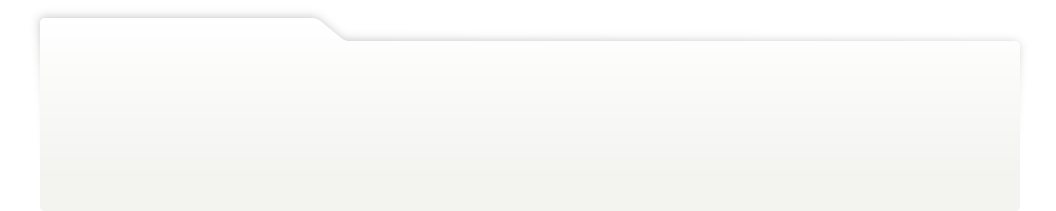
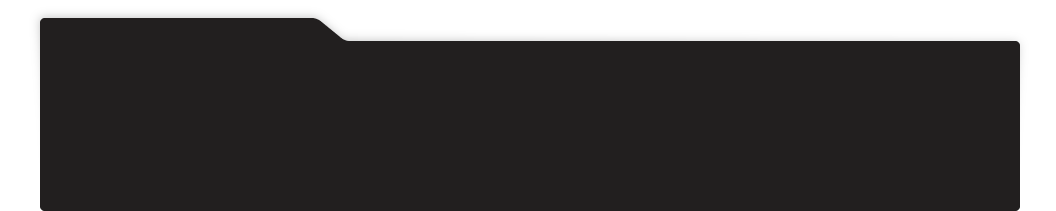
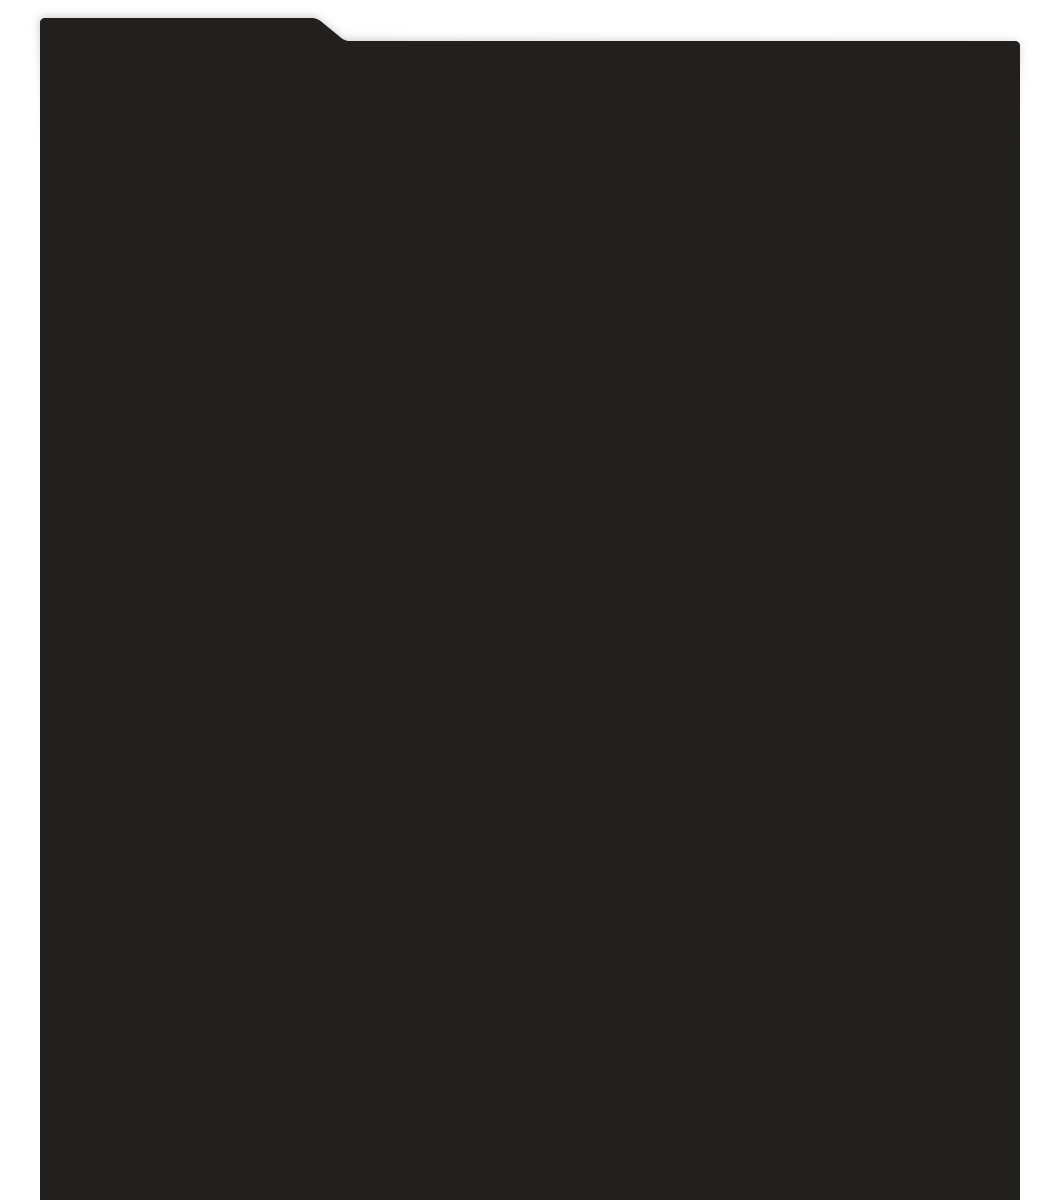
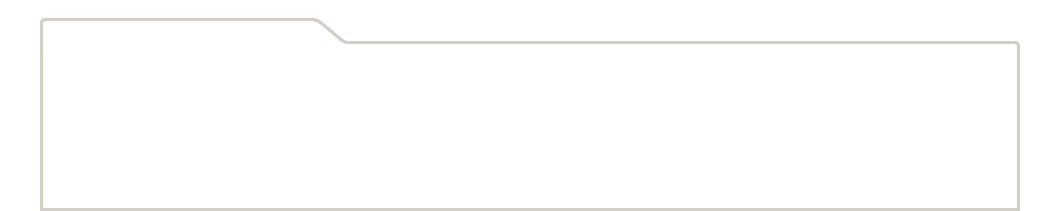
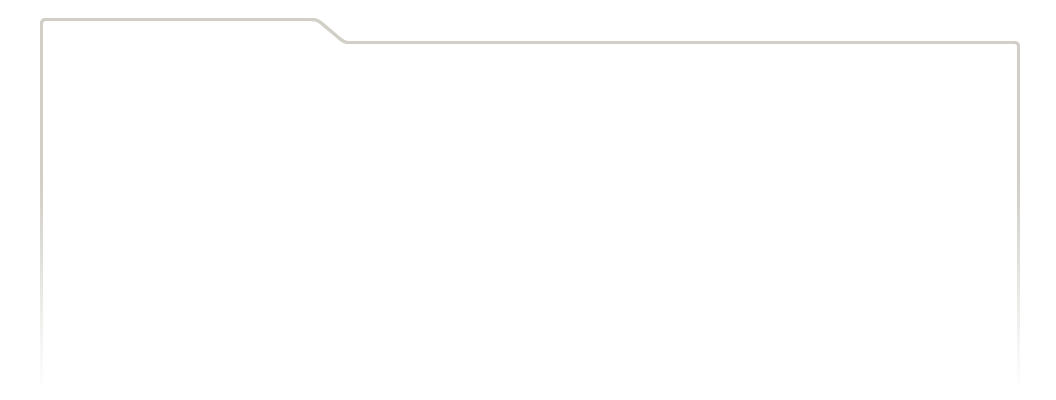
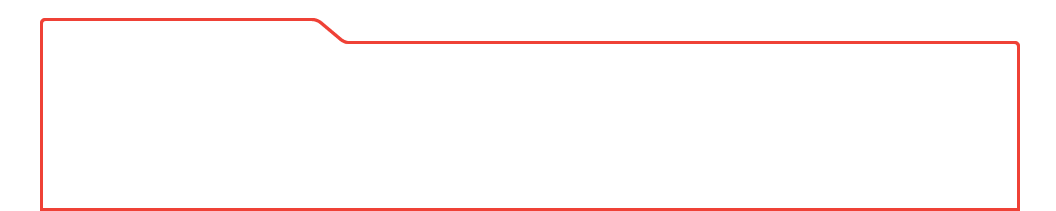
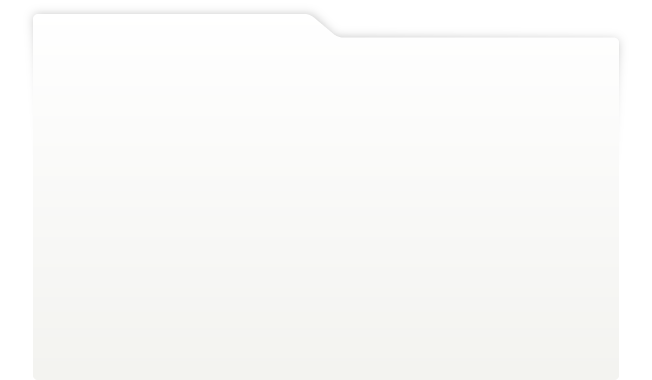
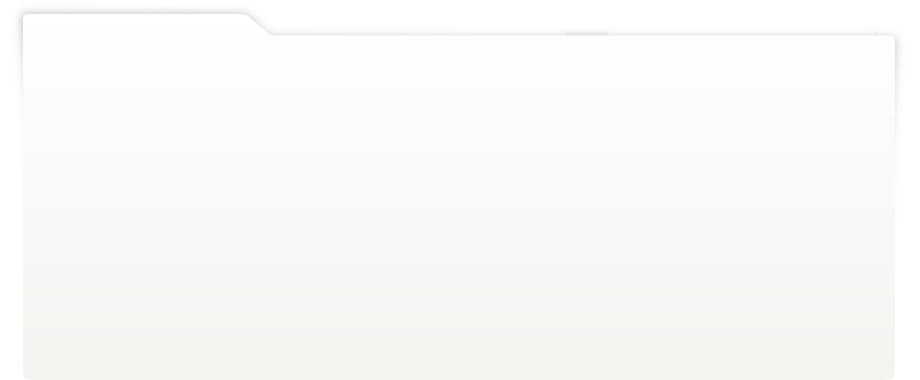
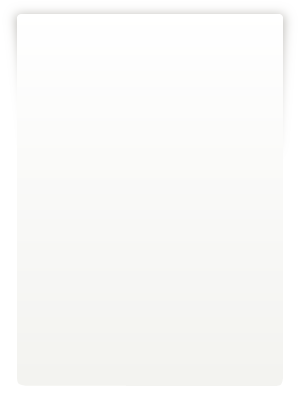
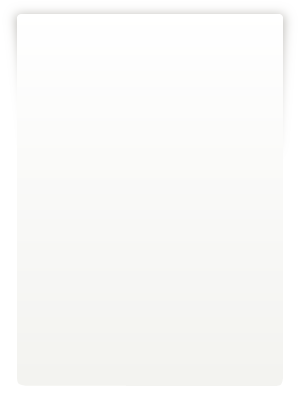
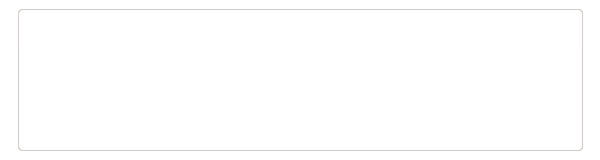
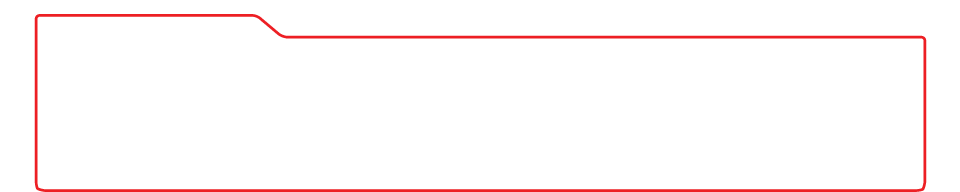
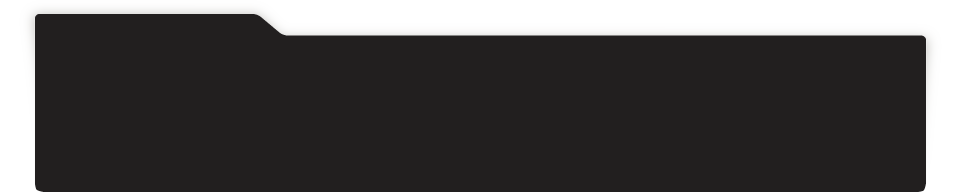
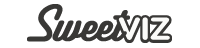
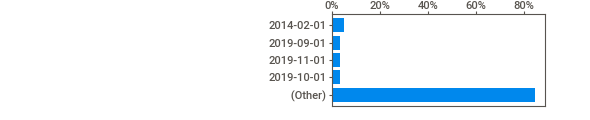
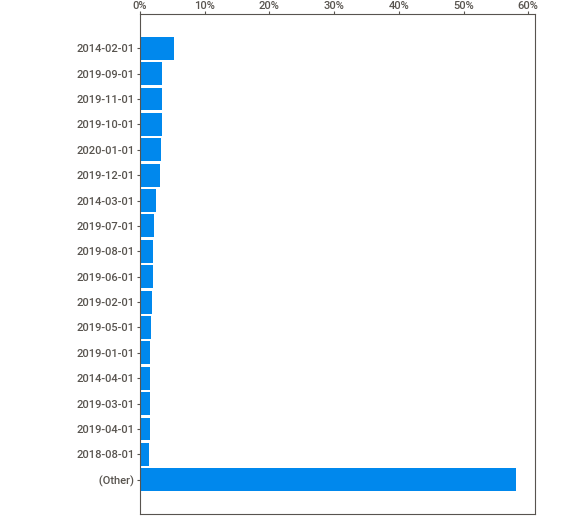
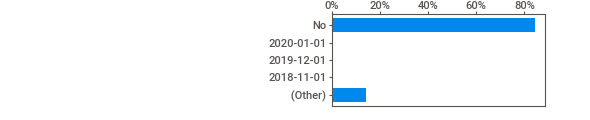
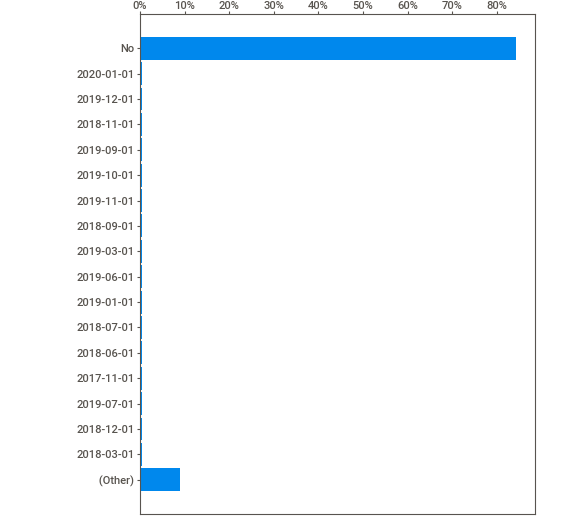
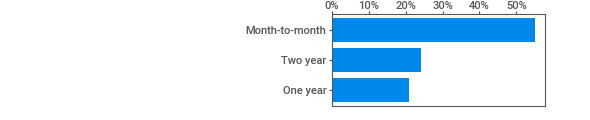
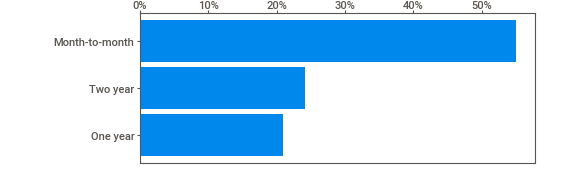
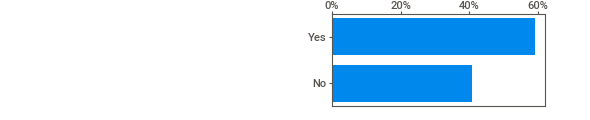
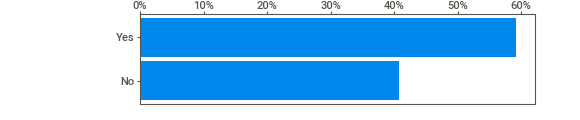
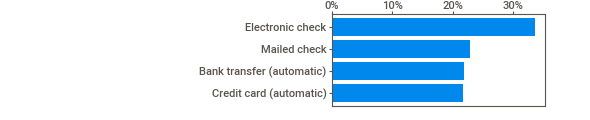
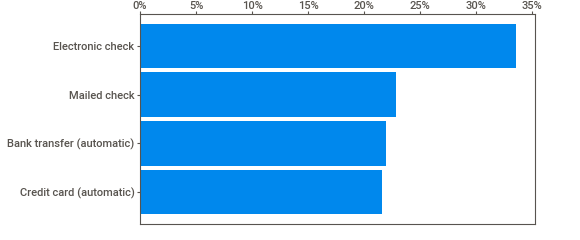
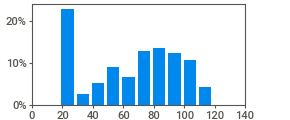
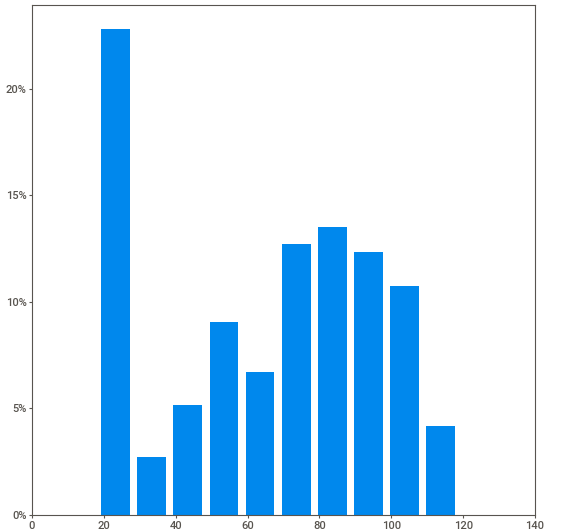
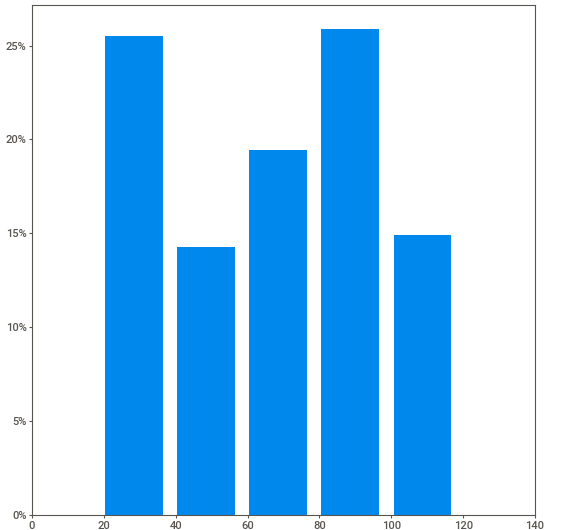
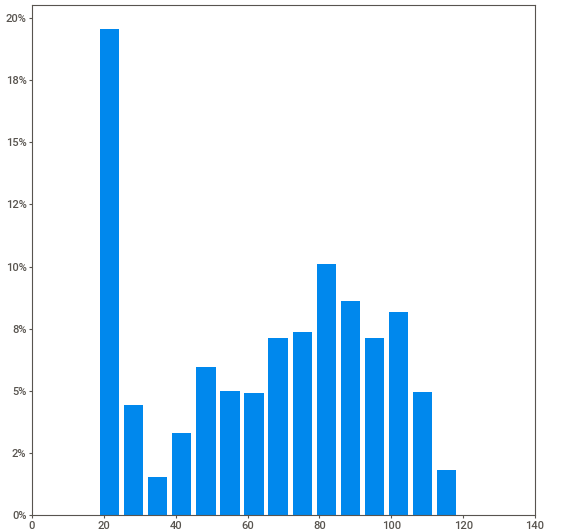
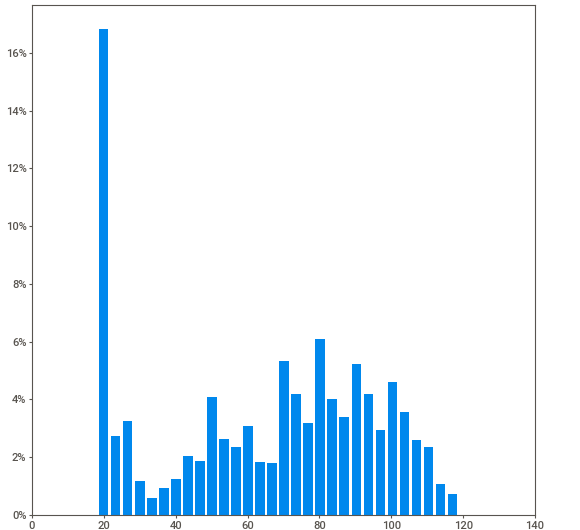
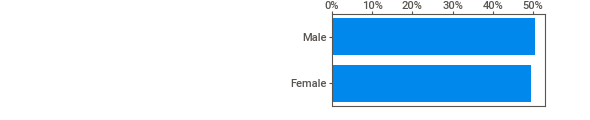
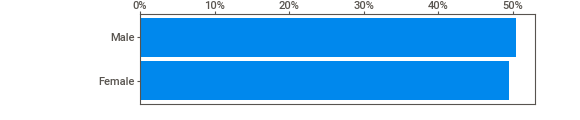
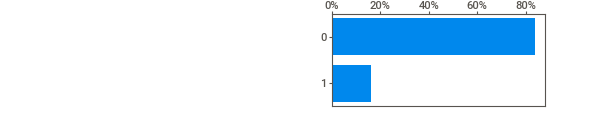
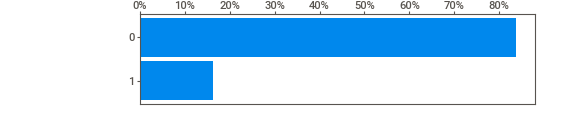
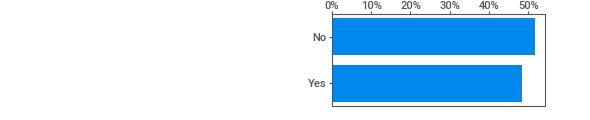
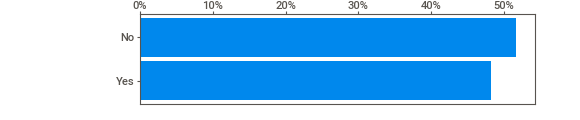
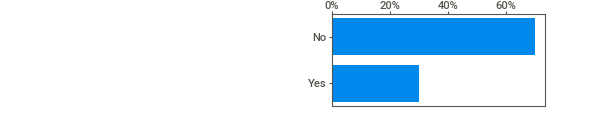
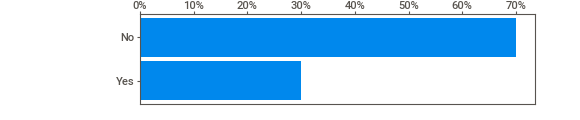
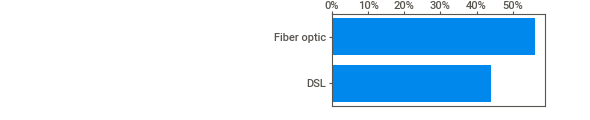
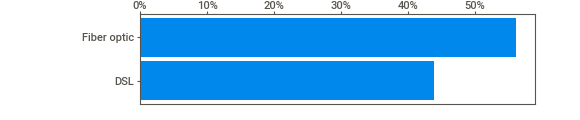
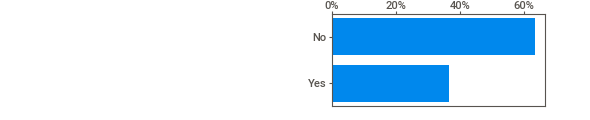
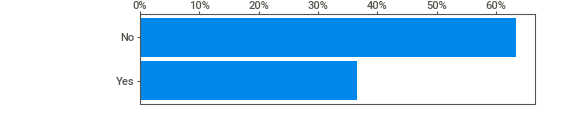
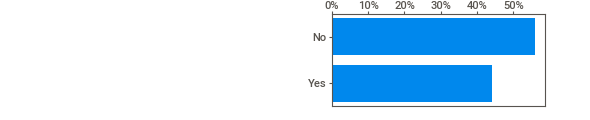
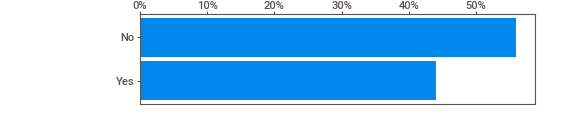
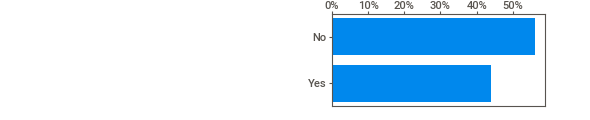
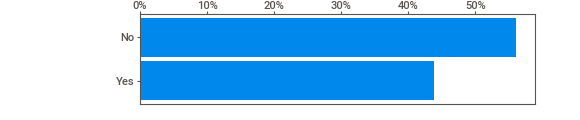
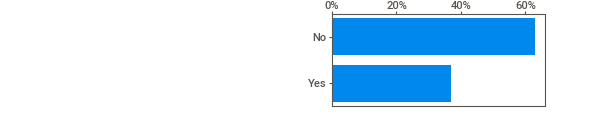
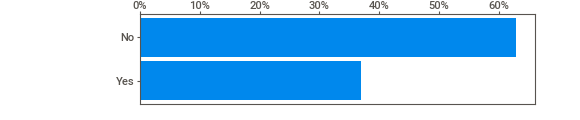
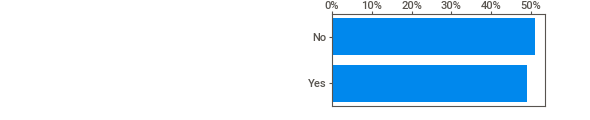
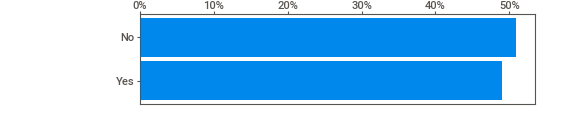
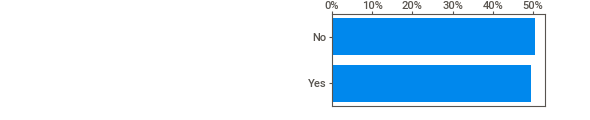
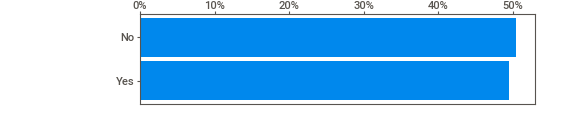
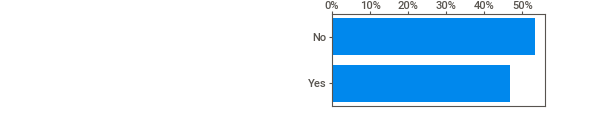
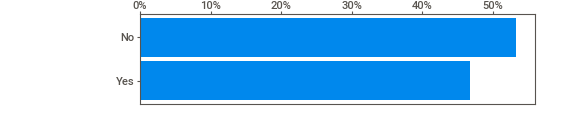
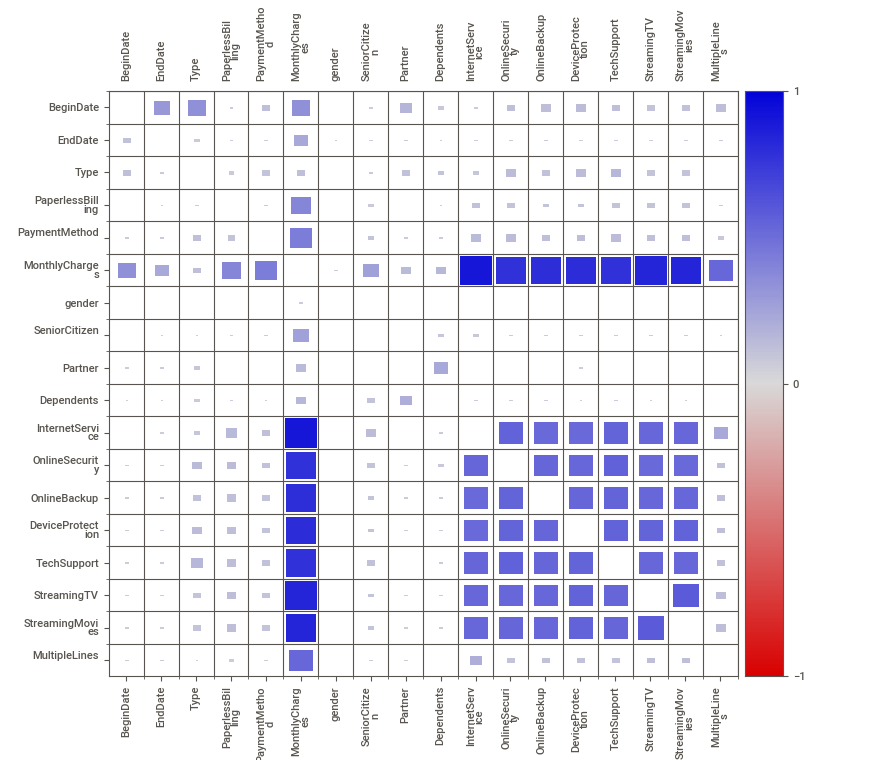
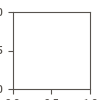

In [12]:
report.show_notebook()

Воспользуемся информацией из отчета и изучим количественные и качественные признаки датасета.

**Посмотрим на показатели количественных признаков в датасете.**

Признак `TotalCharges` рассмотрим позже, когда поменяем тип данных на численный.

Признак `MontlyCharges` имеет следующие параметры:
  
  - бимодальное распределение с вершинами в районе 20-25 и 80-85, со средним 65 и медианной 70
  
  - большинство значений находятся в диапазоне от 36 до 90
  
  - минимальное зачение признака - 18, а максимальное значение - 118

**Посмотрим на показатели категориальных признаков в датасете.**

*По заключенным контрактам:*
 
  - присутствует 3 типа оплаты: ежемесячный (55%), оплата за два года (24%) и оплата за год (21%)

  - присутствует 4 метод оплаты: электронный чек (34%), почтовый чек (23%), банковский перевод и кредитка (по 22 %)

  - электронный платежный документ используют 59%.

*По клиентам:*

 - мужчин и женщин по 50%
 
 - людей пенсионного возраста 16%
 
 - людей состоящих в браке 52%
 
 - людей имеющих иждивенцев 30%
 
*По основным услугам:*

  - услугами интерента пользуется 78% клиентов (из них 56% подключено по оптоволокну и 44% через телефоную линнию)

  - услугами телефонии пользуется 90% клиентов

*По доп услугам:*
  
  - услугами блокировки вредоносных сайтов пользуется 37% клиентов

  - услугой антивируса пользуется 44% клиентов
  
  - услугой техподдержки пользуется 37% клиентов
  
  - услугой облачного хранилища пользуется 44% клиентов
  
  - стриминговое телевидение и каталог с фильмами использует 50% клиентов

  - услугу паралельных линий во время звонка используют 47% клиентов

**Итоги первого этапа:**

 - произведена загрузка четырех датасетов: `contract`, `personal`, `internet` и `phone`
 - произведено объединение четырех датасетов в один по ключевому признаку
 - выведена и изучена вся необходимая информация о датасете

### Предобработка данных

Начнем предобработку даннных с изменения названий столбцов. Для этого достаточно привести названия столбцов к змеиному регистру.

In [13]:
data = data.rename(columns={
    
    'customerID':'customer_id', 'BeginDate':'begin_date', 'EndDate':'end_date', 
    'PaperlessBilling':'paperless_billing', 'Type':'payment_type', 'PaymentMethod':'payment_method', 
    'MonthlyCharges':'monthly_charges','TotalCharges':'total_charges', 'gender':'gender', 
    'SeniorCitizen':'senior_citizen', 'Partner':'partner', 'Dependents':'dependents',
    'InternetService':'internet_service', 'OnlineSecurity':'online_security', 'OnlineBackup':'online_backup',
    'DeviceProtection':'device_protection', 'TechSupport':'tech_support',
    'StreamingTV':'streaming_tv', 'StreamingMovies':'streaming_movies', 'MultipleLines':'multiple_lines'
})

Так как в столбце `end_date` помимо даты содержится информация о том ушел клиент или нет, то из него можно получить целевой признак.

In [14]:
data['churn'] = data['end_date'].apply(lambda x: 'No' if x == 'No' else 'Yes')

Теперь все значения "No" можно заменить на актуальную дату выгрузки датасета указанную в описании.

In [15]:
data['end_date'].replace('No','2020-02-01', inplace=True)

Заменим тип данных в столбцах `begin_date` и `end_date` на более подходящий формат для даты "datetime".

In [16]:
# применим функцию to_datetime для изменения формата на datetime
data['begin_date'] = pd.to_datetime(data['begin_date'], format='%Y-%m-%d')
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%d')

Заменим тип данных в столбце `total_charges` на числовой, а также проверим не появились ли после этого пропуски.

In [17]:
# применим функцию to_numeric для изменения формата на числовой
data['total_charges'] = pd.to_numeric(data['total_charges'], errors='coerce')

In [18]:
data['total_charges'].isna().sum()

11

После изменения типа данных в столбце появилось 11 пропусков. Так как количество небольшое просто удалим их без выяснения причин.

In [19]:
data = data.dropna(subset=['total_charges']).reset_index(drop=True)

Уберем дробную часть в столбцах `total_charges` и `montly_charges` для быстроты последующих расчетов у моделей обучения.

In [20]:
data = data.astype({'total_charges': "int64", 'monthly_charges': "int64"})

Теперь можно изучить показатели признака `total_charges` т.к. он не был рассмотрен ранее из-за неподходящего формата.

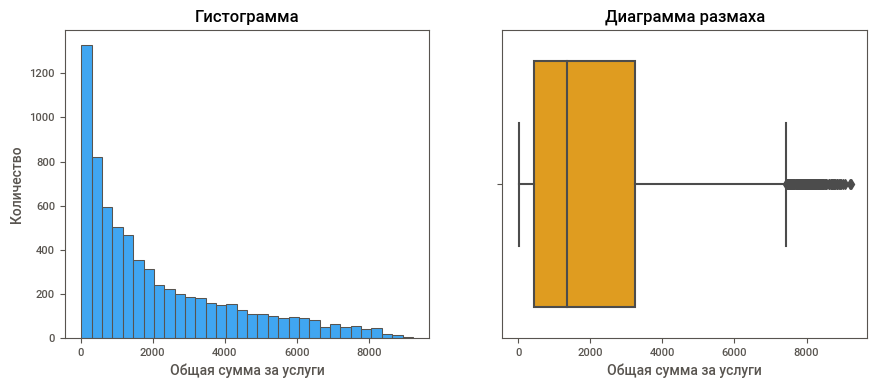

In [21]:
plt.figure(figsize=(16, 4))
# выведем диаграмму распределения признака
plt.subplot(1,3,1)
sns.histplot(data['total_charges'], palette=['blue'])
plt.title('Гистограмма')
plt.xlabel('Общая сумма за услуги')
plt.ylabel('Количество')
# выведем диаграмму размаха признака
plt.subplot(1,3,2)
sns.boxplot(data['total_charges'], palette=['orange'])
plt.title('Диаграмма размаха')
plt.xlabel('Общая сумма за услуги')
plt.show()

Из приведенных выше графиков можно увидеть следующее:

  - распределение пуассона с вытянутым вправо хвостом и с вершиной в районе 20-280
  
  - большинство значений находятся в диапазоне примерно от 450 до 3250
  
  - значения больше 7500 тыс можно считать аномально высокими

Заполним пропуски, образовавшиеся после объединеия датасетов значениями "No Phone" и "No Internet".

В данном случае пропущенные значения появились из-за того, что клиенты не пользуются услугами интернета либо телефонии.

In [22]:
data['multiple_lines'].fillna('No Phone', inplace=True)

In [23]:
data.fillna('No Internet', inplace=True)

Изменим тип данных в признаке `senior_citizen` на нечисловой для удобства в дальнейших исследованиях.

In [24]:
data['senior_citizen'] = data['senior_citizen'].apply(lambda x: 'No' if x == 0  else 'Yes')

Создадим признак `count_days`, который будет показывать сколько дней клиент пользовался либо пользуется услугами компании.

In [25]:
data['count_days'] = (data['end_date'] - data['begin_date']).dt.days

Создадим признак `count_services`, который будет показывать суммарное количество подключенных услуг у клиента.

In [26]:
# создадим список с именами всех дополнительных услуг
service_name = [
    
    'online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies', 'multiple_lines'
]

services = data.copy()

# приведем все значения в признаках с дополнительными услугами в числовой формат
for name in service_name:
    services[name] = services[name].apply(lambda x: 1 if x == 'Yes' else 0)

# суммируем все услуги для каждого клиента и сохраним результат в соответствующей переменной
data['count_services'] = (services['online_security'] + services['online_backup'] + services['device_protection'] + 
            services['tech_support'] + services['streaming_tv'] + services['streaming_movies'] + services['multiple_lines'])

Создадим признак `service_type`, который будет показывать каким видом услуг пользуется клиент: телефоном, интернетом либо и тем и тем.

In [27]:
# заполним признак значением "Only Phone" для тех у кого нет интернета
data.loc[data['internet_service'] == 'No Internet', 'service_type'] = 'Only Phone'
# заполним признак значением "Only Internet" для тех у кого нет телефона
data.loc[data['multiple_lines'] == 'No Phone', 'service_type'] = 'Only Internet'
# остальные значения признака заполним на "Phone and Internet"
data['service_type'].fillna('Phone and Internet', inplace=True)

По завершению предобработки данных выведем еще раз на экран информацию о датасете и посмотрим на результат.

In [28]:
display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           7032 non-null   datetime64[ns]
 3   payment_type       7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   int64         
 7   total_charges      7032 non-null   int64         
 8   gender             7032 non-null   object        
 9   senior_citizen     7032 non-null   object        
 10  partner            7032 non-null   object        
 11  dependents         7032 non-null   object        
 12  internet_service   7032 non-null   object        
 13  online_security    7032 non-null   object        
 14  online_b

None

**Итоги второго этапа:**
 
 - приведены к змеиному регистру все названия признаков
 - выделен из `end_date` целевой признак с оттоком клиентов  
 - заполнены или удалены все присутсвующие в датасете пропуски
 - изменен тип данных в признаках с датами и в признаке с общей суммой
 - созданы признаки `count_days`, `count_services` и `service_type`

### Исследовательский анализ данных

Для более удобного построения графиков создадим функцию `countplots`.

In [29]:
def countplots(features, name_features):
    # параметры для создания одного графика
    if len(features) == 1:
        plt.figure(figsize=(10, 6))
        sns.countplot(data=data, x=features[0], hue="churn");
        plt.xlabel(name_features[0])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[0])
    # параметры для создания двух графиков   
    if len(features) == 2:
        plt.figure(figsize=(16, 4))
        plt.subplot(1,3,1)
        sns.countplot(data=data, x=features[0], hue="churn")
        plt.xlabel(name_features[0])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[0])
        plt.subplot(1,3,2)
        sns.countplot(data=data, x=features[1], hue="churn")
        plt.xlabel(name_features[1])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[1])
        plt.show()
    # параметры для создания трех графиков
    if len(features) == 3:
        plt.figure(figsize=(16, 4))
        plt.subplot(1,3,1)
        sns.countplot(data=data, x=features[0], hue="churn")
        plt.xlabel(name_features[0])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[0])
        plt.subplot(1,3,2)
        sns.countplot(data=data, x=features[1], hue="churn")
        plt.xlabel(name_features[1])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[1])
        plt.subplot(1,3,3)
        sns.countplot(data=data, x=features[2], hue="churn")
        plt.xlabel(name_features[2])
        plt.ylabel('Количество клиентов')
        plt.title(name_features[2])
        plt.show()
    
    else:
        pass        

#### Распределение целевого признака с оттоком клиентов компании.

Выведем на экран диаграмму распределения целевого признака и посмотрим есть ли дисбаланс в классах.

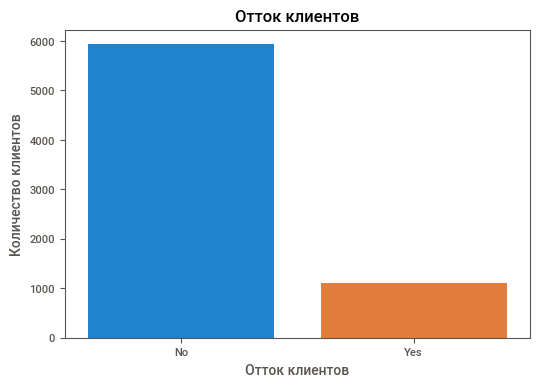

In [30]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x="churn")
plt.xlabel('Отток клиентов')
plt.ylabel('Количество клиентов')
plt.title('Отток клиентов')
plt.show()

Как видно из графика дисбаланс в классах действительно присутствует - оставшихся клиентов примерно в 6 раз больше чем ушедших.

In [31]:
print(f'Процент ушедших от общего количества клиентов: {round(data.churn.value_counts(normalize=True)[1], 2) * 100} %')

Процент ушедших от общего количества клиентов: 16.0 %


#### Анализ количественнных признаков датасета в зависимости от оттока клиентов компании. ####

Посмотрим на распределения всех количественнных признаков в зависимости от оттока клиентов компании.

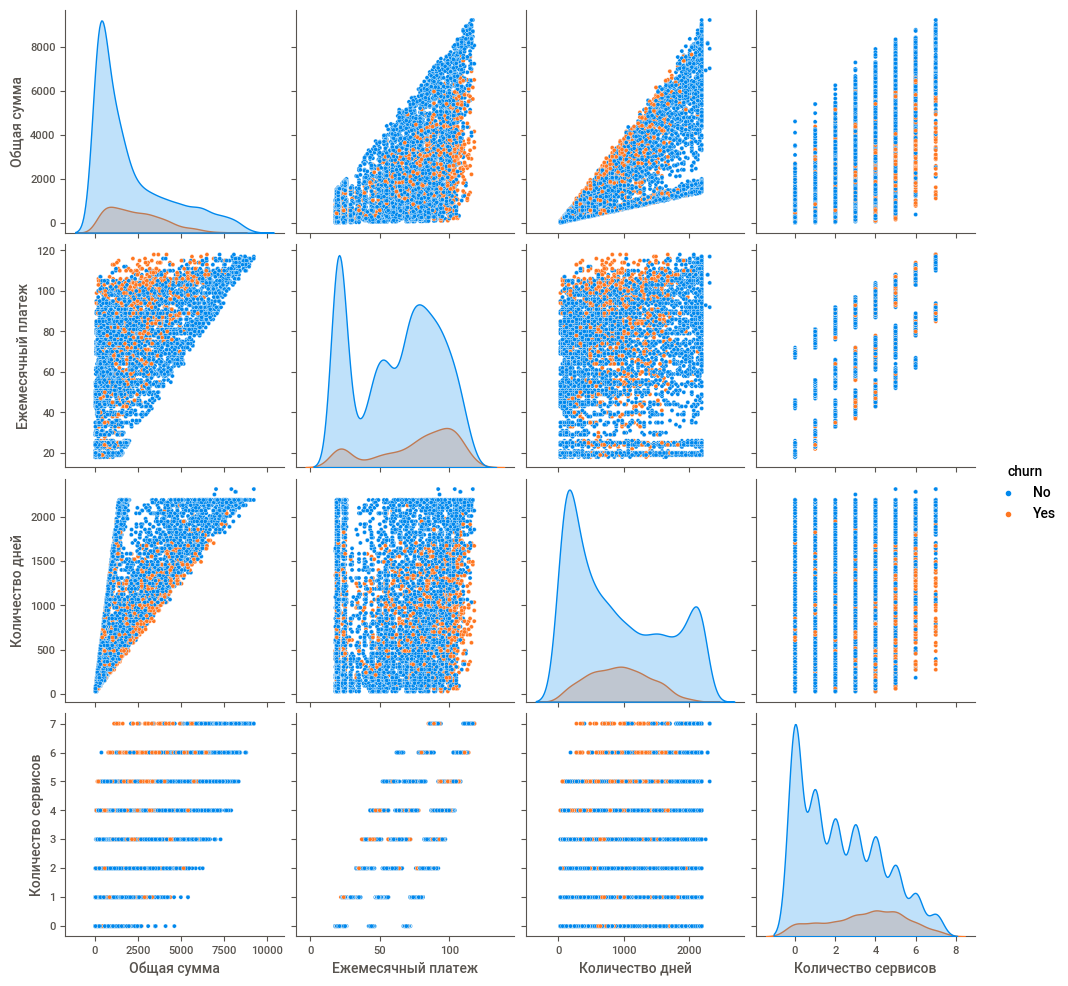

In [32]:
sns.pairplot(data[['total_charges', 'monthly_charges', 'count_days', 'count_services', 'churn']].rename(columns={
    
    'total_charges':'Общая сумма', 'monthly_charges':'Ежемесячный платеж', 
    'count_days':'Количество дней', 'count_services':'Количество сервисов'

}), hue='churn')

plt.show()

Из выше представленных графиков распределения количественных признаков можно увидеть следующее:


   - по признаку `total_charges`: самый высокий процент оттока приходится на диапазон примерно от 1800 до 4200


   - по признаку `monthly_charges`: самый высокий процент оттока у тех, кто платит больше 100 у.е. в месяц 


   - по признаку `count_days`: наибольший процент оттока приходится на диапазон примерно от 800 до 1200 дней


   - по признаку `count_services`: наибольший процент оттока у тех, кто использует четыре и более сервисов

Исходя из всего этого можно предположить, что клиентов не устраивают высокие ежемесячные платежы, и возможно качество сервисов.

#### Анализ категориальных признаков датасета в зависимости от оттока клиентов компании. ####

Построим графики распределения у созданного признака `service_type` в зависимости от оттока клиентов компании.

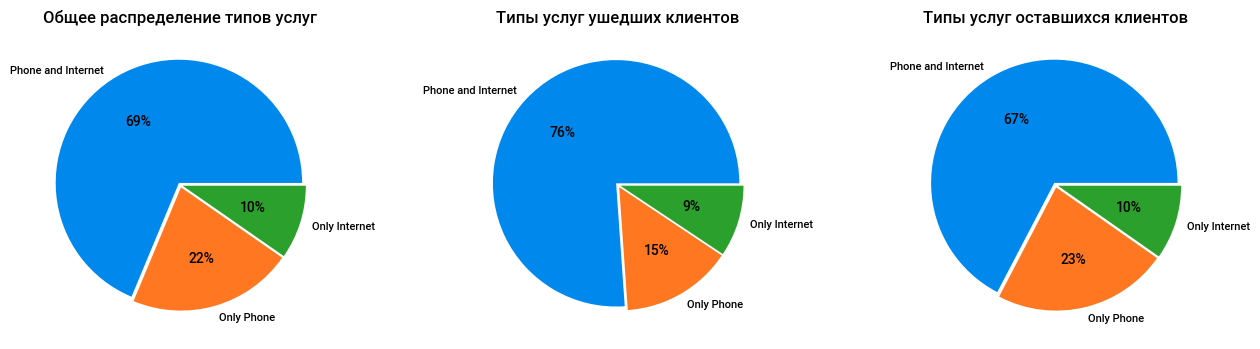

In [33]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
# построим круговую диаграмму общего распредеоения типов услуг среди клиентов
plt.pie(data['service_type'].value_counts(), labels=data['service_type'].value_counts().head().index,
        autopct='%.0f%%', explode =[0.02, 0.02, 0.02]);
plt.title('Общее распределение типов услуг')
plt.subplot(1,3,2)
# построим круговую диаграмму распределения типов услуг среди ушедших клиентов
plt.pie(data[data['churn'] == 'Yes']['service_type'].value_counts(), 
        labels=data[data['churn'] == 'Yes']['service_type'].value_counts().head().index,
        autopct='%.0f%%', explode =[0.02, 0.02, 0.02]);
plt.title('Типы услуг ушедших клиентов')
plt.subplot(1,3,3)
# построим круговую диаграмму распределения типов услуг среди оставшихся клиентов
plt.pie(data[data['churn'] == 'No']['service_type'].value_counts(), 
        labels=data[data['churn'] == 'No']['service_type'].value_counts().head().index, 
        autopct='%.0f%%', explode =[0.02, 0.02, 0.02]);
plt.title('Типы услуг оставшихся клиентов')
plt.show()

 - процент клиентов, пользующихся только телефонией практичестки не меняется во всех трех случаях
 
 
 - процент клиентов, пользующихся только интернетом меньше у тех, кто ушел, чем у оставшихся
 
 
 - процент клиентов, пользующихся и тем и другим больше у тех, кто ушел, чем у оставшихся
 

Вероятно клиенты, у которых подключены обе услуги не пользуются одной из них и решили, что переплачивают за ненужную услугу.

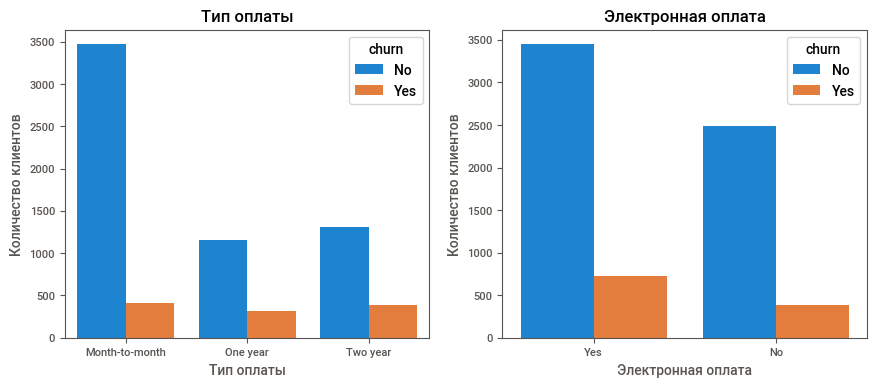

In [34]:
countplots(['payment_type', 'paperless_billing'], ['Тип оплаты', 'Электронная оплата'])

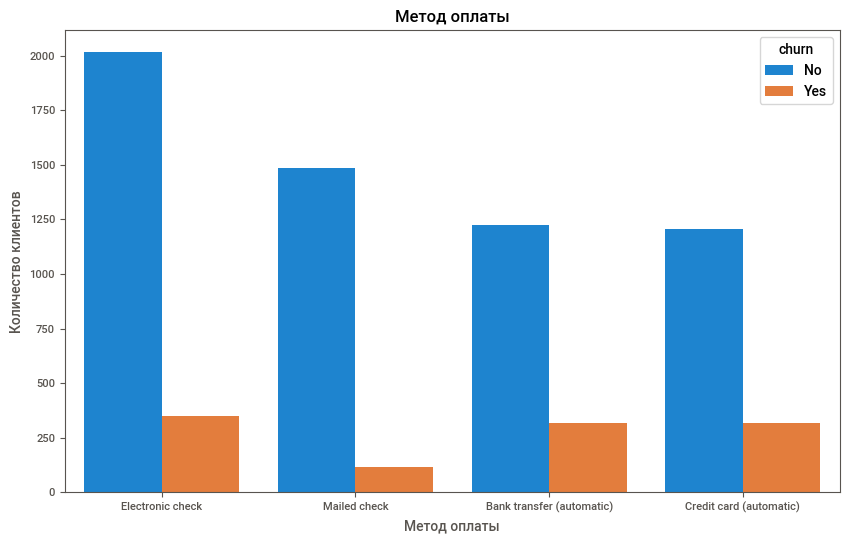

In [35]:
countplots(['payment_method'], ['Метод оплаты'])

 - **по типу оплаты:**  чаще уходят те, кто оплачивает за 1-2 года сразу, чем те, кто оплачивает ежемесячно
 
 
 - **по методу оплаты:**  чаще уходят те, кто оплачивает банковским переводом либо кредитной картой
 
 
 - **по электронной оплате:**  немного чаще уходят те, кто пользуется электронной оплатой

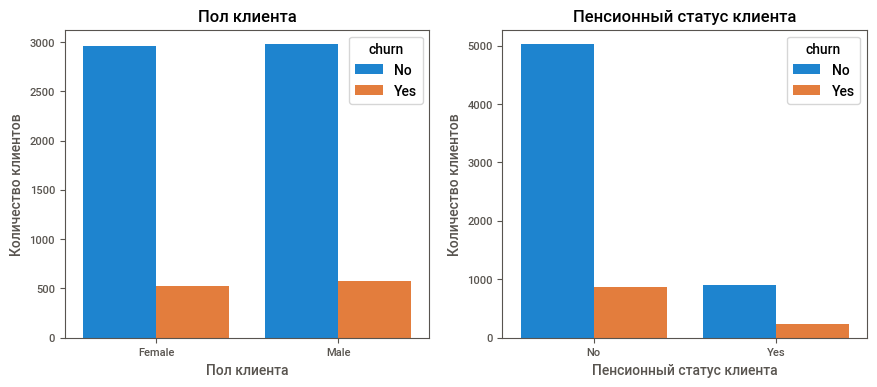

In [36]:
countplots(['gender', 'senior_citizen'], ['Пол клиента', 'Пенсионный статус клиента'])

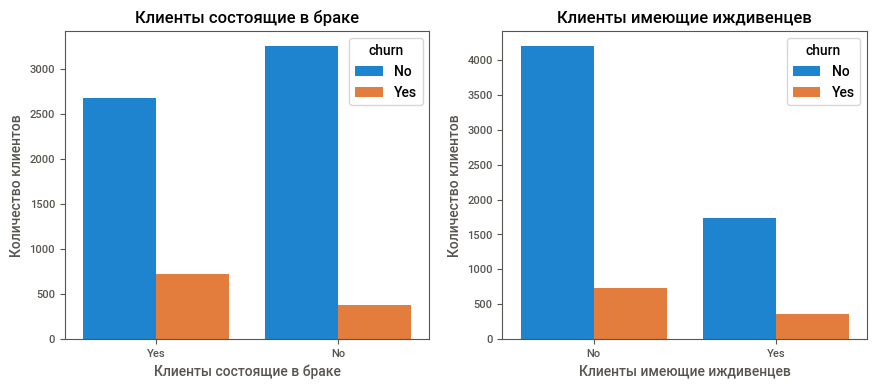

In [37]:
countplots(['partner', 'dependents'], ['Клиенты состоящие в браке', 'Клиенты имеющие иждивенцев'])

 - **пол клиента:** в равной степени уходят как мужчины так и женщины
 
 
 - **пенсионный статус:** пенсионеры уходят немного чаще остальных
 
 
 - **клиенты имеющие иждивенцев:** уходят немного чаще остальных
 

 - **клиенты состоящие в браке:** уходят чаще остальных
 

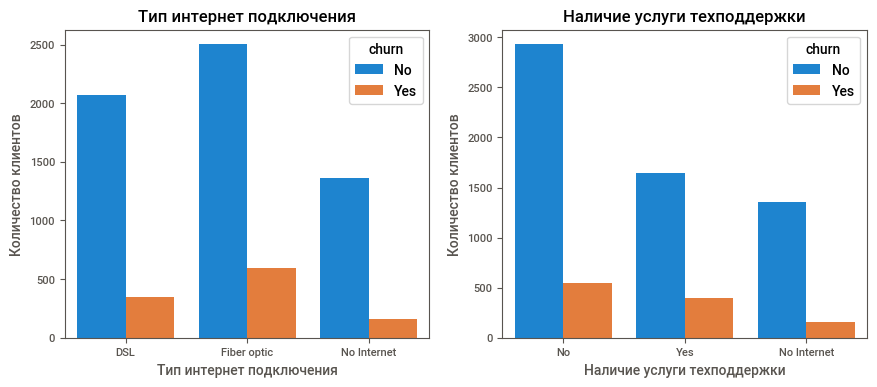

In [38]:
countplots(['internet_service', 'tech_support'], ['Тип интернет подключения', 'Наличие услуги техподдержки'])

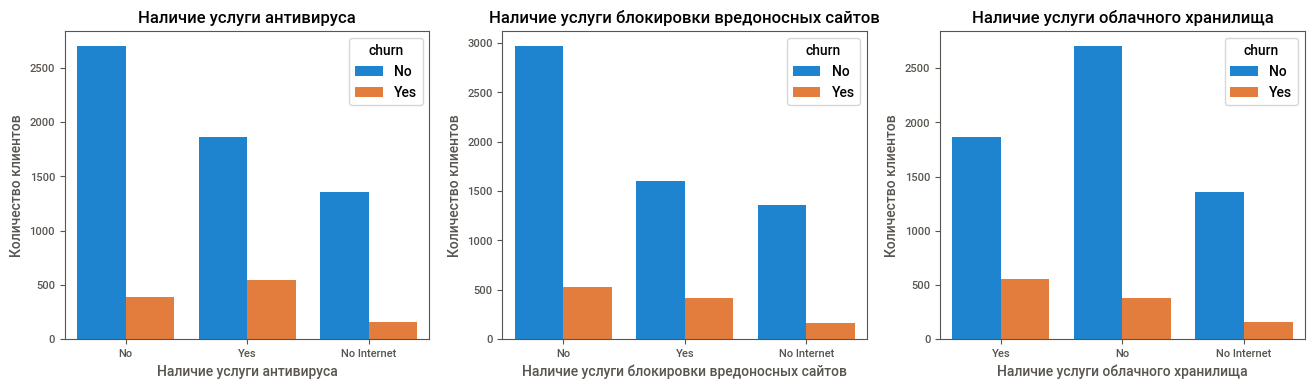

In [39]:
countplots(['device_protection', 'online_security', 'online_backup'], 
    ['Наличие услуги антивируса', 'Наличие услуги блокировки вредоносных сайтов' ,'Наличие услуги облачного хранилища'])

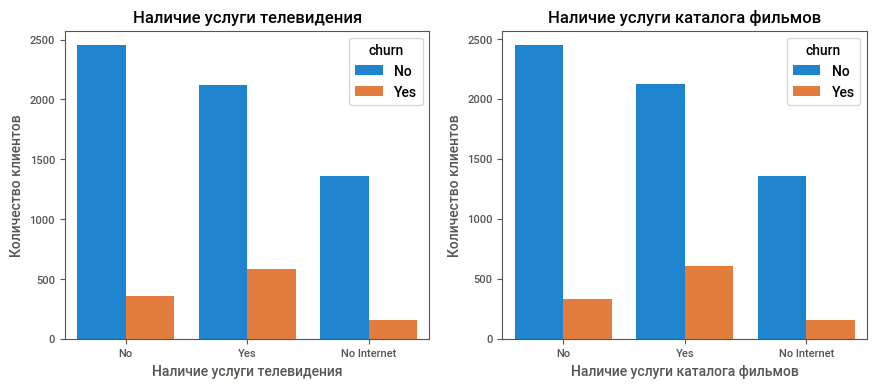

In [40]:
countplots(['streaming_tv', 'streaming_movies'], ['Наличие услуги телевидения', 'Наличие услуги каталога фильмов'])

 - **по типу интернет подключения:** немного чаще уходят те, кто пользуется оптоволокном, чем те у кого DSL
 
 
 - **по дополнительным интернет услугам:** чаще уходят те, у кого подключена дополнительная услуга

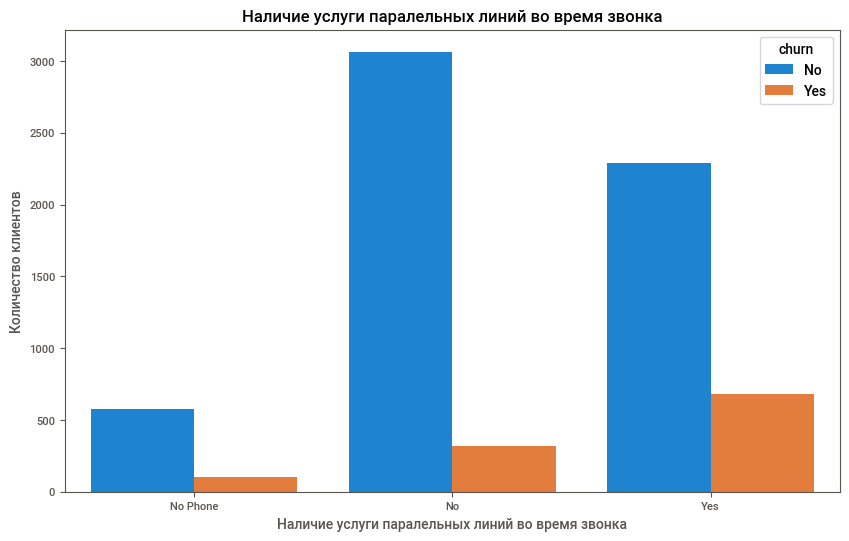

In [41]:
countplots(['multiple_lines'], ['Наличие услуги паралельных линий во время звонка'])

 - **по дополнительным телефонным услугам:** аналогичная ситуация, уходят чаще те, у кого данная услуга подключена

Исходя из всех представленных выше графиков распределения категориальных признаков можно сделать следующие предположения:
   
    
   - наличие проблем с некоторыми видами платежей, таких как банковский перевод и кредитная карта
   
   
   - отсутствие каких либо скидок и соответственно мотивации оплачивать сразу на год или два года
   
    
   - слабая ориентированность на клиентов имеющих семьи и детей и отчасти на пенсионеров
   
    
   - плохое качество или неоправданно высокая цена на подключение интернета по оптоволоконному кабелю
   
    
   - плохое качество или высокая цена всех доп услуг и возможное их навязание клиентам, которым они не нужны

#### Построение корреляционной матрицы количественных и категориальных признаков датасета

In [42]:
# определим численные признаки, чтобы отметить их при построении кореляционной матрицы датасета
interval_cols = data[['total_charges', 'monthly_charges', 'count_days', 'count_services']]

In [43]:
# используем функцию phik_matrix для создания кореляционной матрицы датасета
phik_overview = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1).phik_matrix(interval_cols=interval_cols)

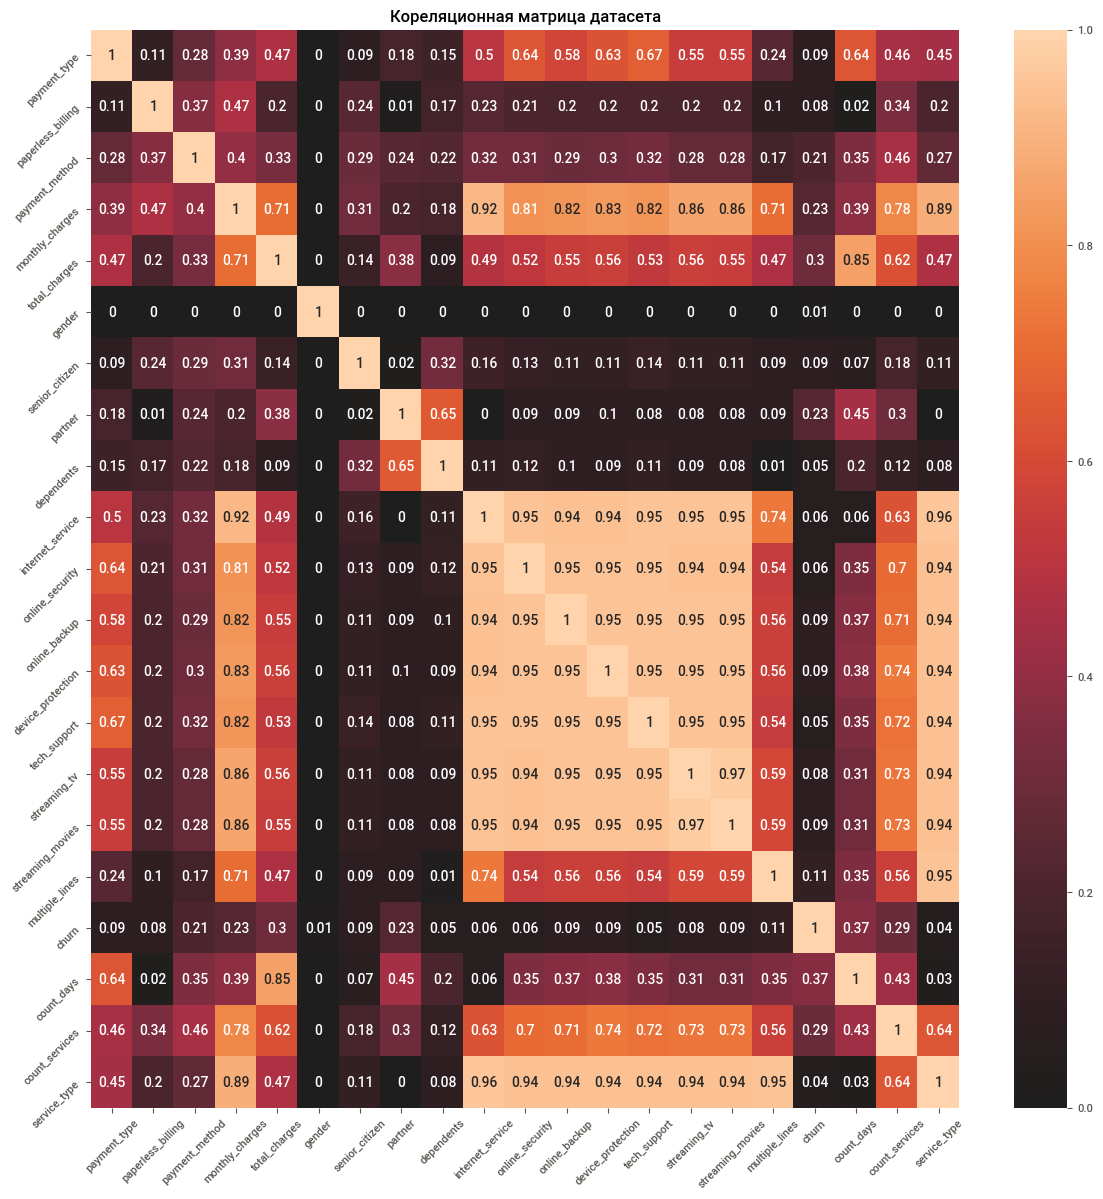

In [44]:
plt.figure(figsize=(14, 14))
# выведем кореляционную матрицу на экран
sns.heatmap(round(phik_overview, 2), center=0, annot=True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Кореляционная матрица датасета')
plt.show()

Из приведенной выше кореляционной матрицы признаков датасета можно сделать следующие выводы:

   - имеется сильная кореляция между ежемесячными платежами и доп услугамами, что логично, наличие услуги увеличивет платеж
   

   - все подключаемые дополнительные интернет услуги (стриминг, поддержка, услуги безопасности и облачное хранилище) имеют крайне высосокую кореляцию между собой (около 0.95), что свидетельствует о том, что данные услуги скорее всего идут вместе по одной подписке
   
   
   - признак пол клиента наоборот, практически ни с чем не колерирует и в данном случае является абсолютно безполезным
   
   
   - стоит отметить что созданный признак `service_type` сильно корелирует с другими признаками в датасете и не корелирует с целевым признаком, что делает его бесполезным в отличие от двух других `count_days` и `count_services`, у которых такая кореляция присутствует

**Итоги третьего этапа:**
  
  - произведен анализ целевого признака на дисбаланс классов
  - произведен анализ категориальных и количественных признаков
  - построена и выведена на экран кореляционная матрица

### Построение и обучение моделей

#### Подготовка данных к обучению и разделение на выборки ####

Изменим тип данных в целевом признаке с оттоком клиентов с объектного на числовой.

In [45]:
data['churn'] = data['churn'].apply(lambda x: 0 if x == 'No' else 1)

Удалим признаки `begin_date`, `end_date` и `customer_id` из датасета, т.к. в обучении моделей они уже не понадобятся.

In [46]:
data = data.drop(['customer_id', 'begin_date', 'end_date'], axis=1)

Удалим признаки с дополнительными интернет услугами из-за мультиколлениальности, а также для быстроты последующих расчетов.

In [47]:
data = data.drop(['online_security', 'online_backup', 'device_protection', 'tech_support',
    'streaming_tv', 'streaming_movies'], axis=1)

Выделим из датасета столбец с целевым признаком. Сохраним признаки в переменной `features`, а целевой признак в переменной `target`.

In [48]:
# удаляем столбец 'churn' и сохраняем в переменной features оставшиеся признаки
features = data.drop('churn', axis=1)
# сохраняем в переменной target столбец с целевым признаком
target = data['churn']

Теперь выделим из датасета тестовую выборку в размере 25% от всего датасета. Валидационную выборку можно не выделять т.к. подбирать подходящие значения гиперпараметров для обучения модели будем через функцию GridSearchCV и использовать кросс-валидацию.

In [49]:
# с помощью функции train_test_split выделим данные для тестовой выборки
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=SEED, stratify=target)

Выведем размер получившихся выборок на экран, а также посмотрим сохранился ли баланс целевого признака при разделении.

In [50]:
print('Размеры обучающей выборки:', features_train.shape, target_train.shape,
      'Размеры тестовой выборки', features_test.shape, target_test.shape)

Размеры обучающей выборки: (5274, 14) (5274,) Размеры тестовой выборки (1758, 14) (1758,)


In [51]:
print('Процент ушедших клиентов в обучающей выборке:', int(target_train.value_counts(normalize=True)[1] * 100), '%', 
      'Процент ушедших клиентов в тестовой выборке:',  int(target_test.value_counts(normalize=True)[1] * 100), '%')

Процент ушедших клиентов в обучающей выборке: 15 % Процент ушедших клиентов в тестовой выборке: 15 %


Выделим отдельно категориальные и числовые признаки и сохраним в переменных для более удобного препроцессинга данных в дальнейшем.

In [52]:
# выделим в отдельную переменную количественные признаки
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
# выделим в отдельную переменную категориальные признаки
cat_features = features_train.select_dtypes(include='object').columns.to_list()

In [53]:
#Код ревьюера
num_features

['monthly_charges', 'total_charges', 'count_days', 'count_services']

Так как присутствует дисбаланс в данных используем `StratifiedKFold` для создания стратифицированных выборок при кросс-валидации.

In [54]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

#### Подбор гиперпараметров и обучение моделей

Создадим функцию `grid_search` для автоматизации поиска гиперпараметров у моделей.

In [55]:
# создаем функцию grid_search
def grid_search(features, target, pipeline, params, name):
    
    # передаем функции GridSearchCV модель и набор значений гиперпараметров для нее
    # кросс-валидации передадим переменную cv, в scoring ставим метрику roc-auc и задействуем все ядра процессора
    # сохраняем все это в созданной переменной grid_search
    grid_search = GridSearchCV(pipeline, params, cv=cv, scoring='roc_auc', n_jobs=-1)
    
    # обучаем модель
    grid_search.fit(features, target)
    
    # получаем предсказания модели
    grid_search.predict(features)
    
    # измеряем скорость обучения модели
    start_time = time.time()
    grid_search.best_estimator_.fit(features, target)
    fit_time = time.time() - start_time
    
    # измеряем скорость предсказания модели
    start_time = time.time()
    grid_search.best_estimator_.predict(features)
    predict_time = time.time() - start_time
    
    # измеряем метрику roc-auc у модели 
    roc_auc_score = round(grid_search.best_score_, 2)
    
    # сохраним все полученные результаты в переменную
    results = [name, fit_time, predict_time, roc_auc_score]
    
    # выведем значение roc-auc модели на экран
    print ('roc_auc_score модели:', roc_auc_score)
    
    # возвращаем обученную наилучшим способом модель ее параметры и результат работы
    return grid_search.best_estimator_, grid_search.best_params_, results

Теперь можно приступать непосредственно к самому исследованию. Для исследования возьмем пять следующих моделей:

 - *Решающее дерево (DecisionTreeClassifier)*
 
 
 - *Случайный лес (RandomForestClassifier)*
 
 
 - *Логистическая регрессия (LogisticRegression)*
 
 
 - *Модель градиентного бустинга CatBoost (CatBoostClassifier)*
 
 
 - *Модель градиентного бустинга LightGBM (LGBMClassifier)*
 

Инициализируем модели, а также выберем необходимые значения гиперпараметров для их перебора функцией `grid_search`.

In [56]:
name_dtc = 'Решающее дерево'

# выберем нужную модель и сохраним в переменной
dtc = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

# создадим параметры для препроцессинга данных
features_dtc = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_dtc = make_pipeline(features_dtc, dtc)

# выберем нужные диапазоны для перебора гиперпараметров
param_grid_dtc = {
    
    'decisiontreeclassifier__max_depth': range(2, 20, 2), 
    'decisiontreeclassifier__min_samples_split': range(2, 20, 2), 
    'decisiontreeclassifier__min_samples_leaf': range(2, 20, 2)    
}

In [57]:
name_rfc = 'Случайный лес'

# выберем нужную модель и сохраним в переменной
rfc = RandomForestClassifier(random_state=SEED, class_weight='balanced')

# создадим параметры для препроцессинга данных
features_rfc = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_rfc = make_pipeline(features_rfc, rfc)

# выберем нужные значения гиперпараметров для модели и сохраним в переменной
param_grid_rfc = {
    
    'randomforestclassifier__max_depth': range(2, 20, 2), 
    'randomforestclassifier__min_samples_split': range(2, 20, 2), 
    'randomforestclassifier__min_samples_leaf': range(2, 20, 2),
    'randomforestclassifier__n_estimators': [20, 50, 80]
}

In [58]:
name_lr = 'Логистическая регрессия'

# инициализируем модель
lr = LogisticRegression()

# создадим параметры для препроцессинга данных
features_lr = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_lr = make_pipeline(features_lr, lr)

# выберем нужные значения гиперпараметров для модели и сохраним в переменной
param_grid_lr = {
    
    'logisticregression__C': [0.01, 0.1, 1, 10, 100]
}

In [59]:
name_catboost = 'CatBoost'

# выберем нужную модель и сохраним в переменной
catboost = CatBoostClassifier(verbose=0, random_state=SEED)

# создадим параметры для препроцессинга данных
features_catboost = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_catboost = make_pipeline(features_catboost, catboost)

# выберем нужные значения гиперпараметров для модели и сохраним в переменной
param_grid_catboost = {
    
    'catboostclassifier__max_depth': range(2, 8, 2),
    'catboostclassifier__learning_rate': [0.2, 0.8],
    'catboostclassifier__iterations': [1000]
}

In [60]:
name_lgbm = 'LightGBM'

# выберем нужную модель и сохраним в переменной
lgbm = LGBMClassifier(verbose=0, random_state=SEED, silent=True)

# создадим параметры для препроцессинга данных
features_lgbm = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_lgbm = make_pipeline(features_lgbm, lgbm)

# выберем нужные значения гиперпараметров для модели и сохраним в переменной
param_grid_lgbm = {
    
    'lgbmclassifier__max_depth': range(2, 8, 2),
    'lgbmclassifier__learning_rate': [0.2, 0.8],
    'lgbmclassifier__n_estimators': [1000]
}

In [61]:
name_dc = 'Константная модель'

# выберем нужную модель и сохраним в переменной
dc = DummyClassifier(strategy = 'stratified', random_state=SEED)

# создадим параметры для препроцессинга данных
features_dc = make_column_transformer((OneHotEncoder(drop='first'), cat_features), (StandardScaler(), num_features))

# создадим пайплан для модели
pipeline_dc = make_pipeline(features_dc, dc)

param_grid_dс = {}

Применим функцию `grid_search`, проверим какие результаты покажут модели и сохраним все данные в соответствующих переменных.

In [62]:
best_model_dtc, best_params_dtc, results_dtc = grid_search(
    features_train, target_train, pipeline_dtc, param_grid_dtc, name_dtc)

roc_auc_score модели: 0.78


In [63]:
best_model_rfc, best_params_rfc, results_rfc = grid_search(
    features_train, target_train, pipeline_rfc, param_grid_rfc, name_rfc)

roc_auc_score модели: 0.82


In [64]:
best_model_lr, best_params_lr, results_lr = grid_search(
    features_train, target_train, pipeline_lr, param_grid_lr, name_lr)

roc_auc_score модели: 0.76


In [65]:
best_model_catboost, best_params_catboost, results_catboost = grid_search(
    features_train, target_train, pipeline_catboost, param_grid_catboost, name_catboost)

roc_auc_score модели: 0.93


In [66]:
best_model_lgbm, best_params_lgbm, results_lgbm = grid_search(
    features_train, target_train, pipeline_lgbm, param_grid_lgbm, name_lgbm)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
roc_auc_score модели: 0.9


In [67]:
best_model_dс, best_params_dc, results_dс = grid_search(
    features_train, target_train, pipeline_dc, param_grid_dс, name_dc)

roc_auc_score модели: 0.51


Сохраним полученные результаты работы моделей в одну таблицу и выведем ее на экран.

In [68]:
# соберем все показатели работы модели в одну таблицу
columns=['Модель', 'Скорость обучения', 'Скорость предсказания', 'Метрика Roc-Auc']

total_results = [results_dtc, results_rfc, results_lr, results_catboost, results_lgbm, results_dс]
total_results_df = pd.DataFrame(data=total_results, columns=columns)

round(total_results_df, 2)

,Модель,Скорость обучения,Скорость предсказания,Метрика Roc-Auc
0,Решающее дерево,0.03,0.02,0.78
1,Случайный лес,0.44,0.08,0.82
2,Логистическая регрессия,0.06,0.03,0.76
3,CatBoost,1.47,0.10,0.93
4,LightGBM,0.39,0.11,0.90
5,Константная модель,0.05,0.03,0.51


По данным из таблицы видно, что лучший результат по метрике Roc-Auc показала модель градиентного бустинга CatBoost (0.93). Также стоит отметить, что все присутствующие модели обучения прошли проверку на адекватность, так как показали результат лучше чем константная модель.

#### Тестирование и анализ лучшей модели обучения

Посмотрим как покажет себя модель CatBoost на тестовых данных и выведем ее результат в метрике Roc-Auc и дополнительно в метрике Accuracy.

In [69]:
pred_proba = best_model_catboost.predict_proba(features_test)[:, 1]

print('Результат модели на тестовых данных по метрике Roc-Auc:', round(roc_auc_score(target_test, pred_proba), 5))

Результат модели на тестовых данных по метрике Roc-Auc: 0.9412


In [70]:
pred = best_model_catboost.predict(features_test)

print('Результат модели на тестовых данных по метрике Accuracy:', round(accuracy_score(target_test, pred), 5))

Результат модели на тестовых данных по метрике Accuracy: 0.93458


Показатели модели на тестовых данных полностью удовлетворяют требованиям техзадания проекта, так как обе метрики больше значения 0.85.

In [71]:
# выведем параметры модели
print(best_params_catboost)

{'catboostclassifier__iterations': 1000, 'catboostclassifier__learning_rate': 0.2, 'catboostclassifier__max_depth': 2}


Построим и выведем на графиках ROC-кривую и матрицу ошибок для лучшего понимания предсказаний данной модели обучения. 

In [72]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba) 

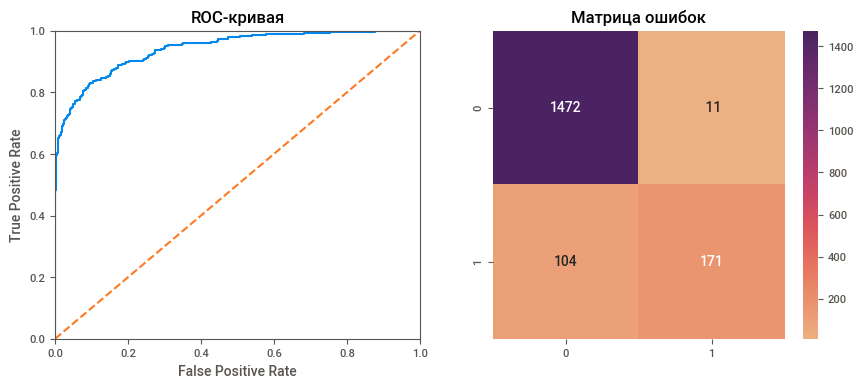

In [73]:
plt.figure(figsize=(16, 4))
plt.subplot(1,3,1)
# выведем roc-кривую на график
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.subplot(1,3,2)
# выведем матрицу ошибок на график
sns.heatmap(confusion_matrix(target_test, pred), annot=True, fmt='3.0f', cmap="flare")
plt.title("Матрица ошибок")
plt.show()

По завершению данного этапа построим и выведем на график наиболее важные признаки, на которые ориентировалась модель при прогнозах.

In [74]:
# инициализируем модель с готовыми гиперпараметрами
model_catboost = CatBoostClassifier(
    cat_features=cat_features, max_depth=2, learning_rate=0.2, iterations=1000, verbose=0, random_state=SEED)
# обучим модель на данных, чтобы получить список важных признаков
model_catboost.fit(features_train, target_train)

In [75]:
# получим и сохраним список важных признаков, отсортируем по убыванию, а затем визуализируем на графике
feat_imp = pd.Series(data=model_catboost.get_feature_importance(), index=features_train.columns).sort_values(ascending=False)

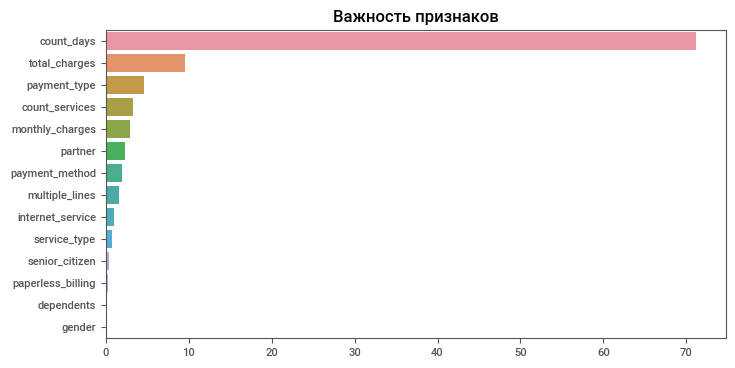

In [76]:
# построим график важности признаков
plt.figure(figsize=(8, 4))
sns.barplot(y=feat_imp.index, x=feat_imp.values, orient='h')
plt.title("Важность признаков")
plt.show()

По графику видно, что наиболее важные признаки это `count_days`, `total_charges`, `count_services`, `payment_type` и `monthly_charges`.

**Итоги четвертого этапа:**

 - произведено разделение датасета на обучающую и тестовую выборки
 - создана функция для автоматизации подбора гиперпараметров у моделей
 - произведено исследование пяти моделей обучения и проверка их на адекватность
 - выбрана лучшая модель обучения (в данном случае это модель CatBoost)
 - произведена проверка модели на тестовых данных по двум метрикам
 - выведена на графики ROC-кривая, матрица ошибок, а также важность признаков

### Общий вывод по проекту

В данном проекте была поставлена задача построить модель, которая бы определяла вероятность ухода клиента с точностью больше 0.85 по метрике Roc-Auc. 


Для выполнения поставленной задачи по предсказанию оттока клиентов были сделаны следующие шаги:

  - заменены пропуски в данных на "No Interntet" и "No Phonе", т.к были клиенты, которые пользовались только одним типом услуг
  
  
  - изменены типы данных в столбцах с датами и в столбце с общей суммой, т.к. они не соответствовали нужным стандартам
  
  
  - созданы дополнительные признаки такие как: количество дней, количество интернет сервисов и тип услуги у клиента
  
  
  - исследован и обнаружен дисбаланс в целевом признаке, выяснилось, что оставшихся клиентов было в 6 раз больше чем ушедших
  
  
  - иследованы количественные и категориальные признаки взависимости от оттока клиентов и сделаны следующие предположения:
  
     
     - недовольство клиентов высокими ежемесячными платежами и качеством дополнительных сервисов
     - проблемы с некоторыми видами оплаты такими как банковский перевод и кредитная карта
     - плохая ориентированность компании на семейных клиентов с детьми и пенсионеров
     - высокая цена и плохое качество доп услуг, а также навязывание их клиентам
     
     
  - создана кореляционнная матрица датасета и проведена проверка признаков на мультиколлениальность
  
  
  - удалены ненужные признаки, такие как идентификатор клиента, признаки с датами, а также признаки с доп услугами
  
  
  - произведено разделение датасета на тренировочную и обучающую выборку в размере 75% и 25% соответственно
  
  
  - выполнен препроцессинг данных, а именно кодирование категориальных признаков и стандартизация данных
  
  
  - произведено обучение пяти моделей: Решающее Дерево, Случайный Лес, Логистическая регрессия, а также CatBoost и LightGBM
  
  
  - выбрана лучшая модель обучения, ей оказалась модель градиентного бустинга CatBoost
  
  
  - произведена проверка лучшей модели на тестовых данных, а также выведены важные признаки, на которые ориентировалась модель
  
  

При реализации данного проекта были выполнены все этапы, заявленные в начале работы над проектом.


Каких-либо трудностей в результате работы над проектом замечено не было.


При обучение модели были использованы все признаки, кроме идентификатора клиента, признаков с датами, а также признаков с доп услугами.

**Итоговая модель:** модель градиентного бустинга CatBoost

**Параметры итоговой модели:** "iterations" - 1000, "learning_rate" - 0.2, "max_depth" - 2

**Результат итоговой модели на тестовых данных:** метрика **Roc-Auc** - **0.94**, метрика **Accuracy** - **0.935**.